# Taxi Tip Prediction

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [125]:
raw_data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv')
df = raw_data.head(100000)

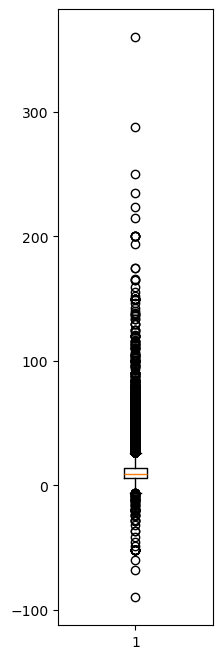

In [126]:
plt.figure(figsize=(2,8))
plt.boxplot(df["fare_amount"])
plt.show()

<Axes: >

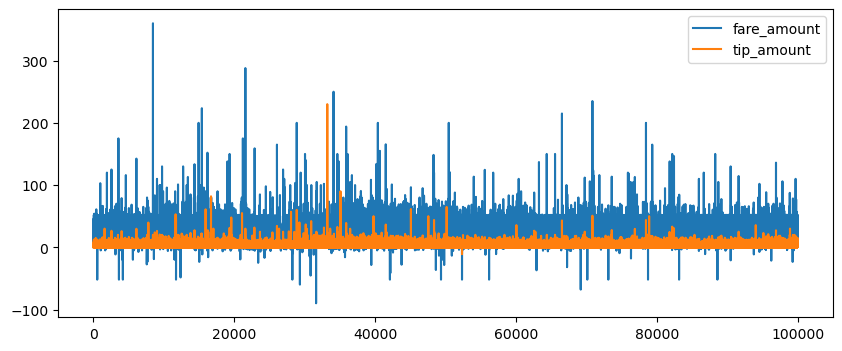

In [127]:
df[['fare_amount', 'tip_amount']].plot(kind="line", figsize=(10,4))

In [128]:
df = df[raw_data['tip_amount'] > 0]
df = df[(df['tip_amount'] <= df['fare_amount'])]
df = df[((df['fare_amount'] >=2) & (df['fare_amount'] < 200))]
df = df.drop(['total_amount'], axis=1)

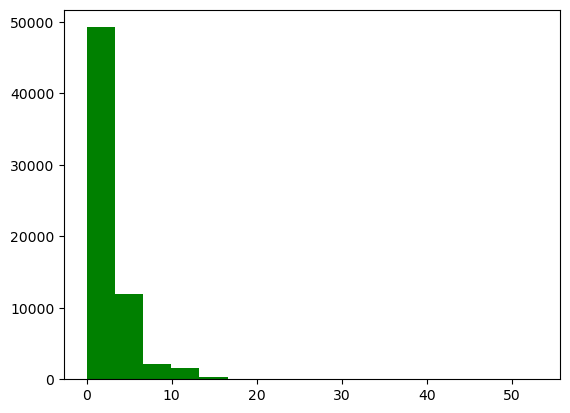

Minimum amount value is  0.01
Maximum amount value is  53.0
90% of the trips have a tip amount less or equal than  5.15


In [129]:
plt.hist(df['tip_amount'], 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", min(df['tip_amount']))
print("Maximum amount value is ", max(df['tip_amount']))
print("90% of the trips have a tip amount less or equal than ",df['tip_amount'].quantile(0.9))

In [130]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65349 entries, 4 to 99999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65349 non-null  int64         
 1   tpep_pickup_datetime   65349 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  65349 non-null  datetime64[ns]
 3   passenger_count        65349 non-null  float64       
 4   trip_distance          65349 non-null  float64       
 5   RatecodeID             65349 non-null  float64       
 6   store_and_fwd_flag     65349 non-null  object        
 7   PULocationID           65349 non-null  float64       
 8   DOLocationID           65349 non-null  float64       
 9   payment_type           65349 non-null  float64       
 10  fare_amount            65349 non-null  float64       
 11  extra                  65349 non-null  float64       
 12  mta_tax                65349 non-null  float64       
 13  tip_am

In [131]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

df['pickup_day'] = df['tpep_pickup_datetime'].dt.weekday
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.weekday

df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,...,0.5,2.65,0.0,0.3,2.5,0,0,5,5,12.283333
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,0,5,5,10.866667
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,...,0.5,1.00,0.0,0.3,2.5,0,1,5,5,8.133333
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,...,0.5,7.05,0.0,0.3,2.5,0,1,5,5,34.016667
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,...,0.5,2.96,0.0,0.3,2.5,0,0,5,5,14.300000


In [132]:
df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
df = pd.get_dummies(df, columns = get_dummy_col)
df.head(2)

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,...,pickup_day_0,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,dropoff_day_0,dropoff_day_3,dropoff_day_4,dropoff_day_5,dropoff_day_6
4,1.0,1.7,9.5,3.0,0.5,2.65,0.0,0.3,2.5,12.283333,...,False,False,False,True,False,False,False,False,True,False
5,2.0,1.6,9.5,3.0,0.5,1.00,0.0,0.3,2.5,10.866667,...,False,False,False,True,False,False,False,False,True,False


In [133]:
y = df[['tip_amount']].astype('float32')
df = df.drop(['tip_amount'], axis=1)
X = df
X = normalize(X, axis=1, norm='l1', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
dt = DecisionTreeRegressor(max_depth=8, random_state=35)

t0 = time.time()
dt.fit(X_train, y_train)
time = time.time()-t0
print(time)

yhat = dt.predict(X_test)
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
print(mse, r2, sep=" - ")

2.0622572898864746
1.6208206336564819 - 0.7204473468621811
